In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from ydata_profiling import ProfileReport
from sklearn.feature_selection import SelectFromModel
import plotly.express as px  # interactive charts
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd
import numpy as np
from src.exception import CustomException
import os
from src.logger import logging
import sys
from datetime import datetime
from src.utils import DatabaseManager
from src.components.variable import dataBase
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

class DataCleaning:
    def __init__(self):
        self.db = DatabaseManager()
        self.conn = dataBase.conn

    def process_data_and_reduce_dimensionality(self, filename):

        try:
            logging.info('Database table reading start in data_process.py')
            df=self.db.execute_query(f'select * from {filename}',fetch=True)
            logging.info('In data_process.py database table converted into df')

        except Exception as e:
            logging.info('Exception occurred at data_process.py in table reading from db stage')
            raise CustomException(e,sys)

        # Process df data
        df['dt_customer'] = pd.to_datetime(df['dt_customer']) #dt_customer
        newest_customer_date = df['dt_customer'].max()
        oldest_customer_date = df['dt_customer'].min()
        df['Customer_For'] = (newest_customer_date - df['dt_customer']).dt.days

        current_year = datetime.now().year
        df['Age'] = current_year - df['year_birth']
        df['Spent'] = df[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum(axis=1)
        df['living_with'] = df['marital_status'].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Single", "Widow": "Single", "YOLO": "Single", "Divorced": "Single", "Single": "Single"})
        df['children'] = df['kidhome'] + df['teenhome']
        df['Family_Size'] = df['living_with'].replace({"Single": 1, "Partner": 2})
        df['Is_Parent'] = np.where(df['children'] > 0, 1, 0)
        df['education'] = df['education'].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
        df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors="coerce")
        # df.loc[(df['Age'] >= 13) & (df['Age'] <= 19), 'AgeGroup'] = 'Teen'
        # df.loc[(df['Age'] >= 20) & (df['Age']<= 39), 'AgeGroup'] = 'Adult'
        # df.loc[(df['Age'] >= 40) & (df['Age'] <= 59), 'AgeGroup'] = 'Middle Age Adult'
        # df.loc[(df['Age'] > 60), 'AgeGroup'] = 'Senior Adult'
        df.rename(columns={
            "mntwines": "Wines",
            "mntfruits": "Fruits",
            "mntmeatproducts": "Meat",
            "mntfishproducts": "Fish",
            "mntsweetproducts": "Sweets",
            "mntgoldprods": "Gold"
        }, inplace=True)


        filename2 = 'Without_encoding'

        try:
            self.db.execute_values(df, filename2)
            logging.info('DataFrame data values have been successfully uploaded to the database table')

        except Exception as e:
            logging.info('Exception occurred at data_process.py file during creating table/execute_value')
            raise CustomException(e, sys)


        data = df.copy()
        to_drop = ["marital_status", "dt_customer", "z_costcontact", "z_revenue", "year_birth", "id"]
        data.drop(to_drop, axis=1, inplace=True)

        data.Is_Parent = pd.to_numeric(data.Is_Parent, errors='coerce')



        #Get list of categorical variables
        s = (data.dtypes == 'object')
        object_cols = list(s[s].index)

        LE = LabelEncoder()
        for i in object_cols:
            data[i] = LE.fit_transform(data[i])
            
        print("All features are now numerical")


        
        filename1 = 'cleaned_data'

        try:
            # self.db.create_table(data, filename1)
            # logging.info(f'Successfully created table in the database table name: {filename1}')



            self.db.execute_values(data, filename1)
            logging.info('DataFrame data values have been successfully uploaded to the database table')

        except Exception as e:
            logging.info('Exception occurred at data_process.py file during creating table/execute_value')
            raise CustomException(e, sys)

        return filename1,filename2

# data_transformer = DataTransformationConfig()

# # Step 2: Load your data into a pandas DataFrame
# # Assuming you have your data in a CSV file named 'customer_data.csv'
# db=DatabaseManager()
# customer_data = db.execute_query('select * from marketing_campaign',fetch=True)

# # Step 3: Call the process_data_and_reduce_dimensionality method and pass the DataFrame
# filename1= data_transformer.process_data_and_reduce_dimensionality(customer_data)

# df1=db.execute_query(f'select * from {filename1}',fetch=True)
# logging.info(f'file names is : {filename1}')
# logging.info(f'df1: \n {df1.head()}')

In [6]:
from src.utils import DatabaseManager

db=DatabaseManager()
df=db.execute_query('select * from merge_table',fetch=True)

In [7]:
df['children'].value_counts()

children
1    1128
0     638
2     421
3      53
Name: count, dtype: int64

In [8]:
children_counts = df['children'].value_counts()

fig = px.pie(children_counts, 
             values = children_counts.values, 
             names = children_counts.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20,
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()

In [9]:
df1=df[df.clusters=='1']
df1

,education,income,kidhome,teenhome,recency,wines,fruits,meat,fish,sweets,...,complain,response,customer_for,age,spent,living_with,children,family_size,is_parent,clusters
0,0.0,58138.0,0,0,58,635,88,546,172,88,...,0,1,663,66,1617,0.0,0,1,0.0,1
2,0.0,71613.0,0,0,26,426,49,127,111,21,...,0,0,312,58,776,1.0,0,2,0.0,1
12,0.0,63033.0,0,0,82,194,61,480,225,112,...,0,0,226,64,1102,0.0,0,1,0.0,1
15,1.0,82800.0,0,0,23,1006,22,115,59,68,...,0,1,582,77,1315,0.0,0,1,0.0,1
18,1.0,76995.0,0,1,91,1012,80,498,0,16,...,0,0,458,74,1782,1.0,1,2,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,1.0,75777.0,0,0,12,712,26,538,69,13,...,0,1,360,41,1438,0.0,0,1,0.0,1
2228,2.0,NaN,0,0,53,32,2,1607,12,4,...,0,0,686,45,1679,1.0,0,2,0.0,1
2233,0.0,666666.0,1,0,23,9,14,18,8,1,...,0,0,392,46,62,1.0,1,2,1.0,1
2235,0.0,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,56,1341,1.0,1,2,1.0,1


In [10]:
cluster_purchases=df[['numdealspurchases','numwebpurchases','numcatalogpurchases','numstorepurchases','numwebvisitsmonth']]
cluster_purchases

,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth
0,3,8,10,4,7
1,2,1,1,2,5
2,1,8,2,10,4
3,2,2,0,4,6
4,5,5,3,6,5
...,...,...,...,...,...
2235,2,9,3,4,5
2236,7,8,2,5,7
2237,1,2,3,13,6
2238,2,6,5,10,3


In [11]:
import plotly.express as px

# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cluster_purchases.index,
             y=cluster_purchases.values,
             color=cluster_purchases.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'Clusters', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cluster_purchases.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (2240, 5) instead

In [ ]:
cam=df1[['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4','acceptedcmp5', 'response']].sum()
cam

acceptedcmp1    128
acceptedcmp2     21
acceptedcmp3     50
acceptedcmp4     87
acceptedcmp5    156
response        168
dtype: int64

In [ ]:
# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cam.index,
             y=cam.values,
             color=cam.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'campaign', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cam.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


In [ ]:
cluster_purchases = df1.groupby('clusters')[['numdealspurchases', 'numwebpurchases', 'numcatalogpurchases',
                                                  'numstorepurchases', 'numwebvisitsmonth']].sum()

cluster_purchases.plot(kind='bar', color=['#dc4c4c','#157394','#589cb4','#bcb4ac','#3c444c'], figsize=(9,7))

plt.title('Purchasing Habits by Cluster')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Purchases', fontsize=20, labelpad=20)
plt.xticks(rotation=0, ha='center')

NameError: name 'df1' is not defined

In [ ]:
income=df[df.clusters=='1'].income.mean()

AttributeError: 'DataFrame' object has no attribute 'clusters'

In [ ]:
((55000-income)/income)*100

NameError: name 'income' is not defined

In [ ]:
df.income.mean()-40000

12247.251353790612

In [ ]:
result = df.groupby('clusters')['income'].agg(
    mean='mean',
    median='median',
    min='min',
    max='max'
).reset_index()

result

KeyError: 'clusters'

<Axes: xlabel='income', ylabel='Count'>

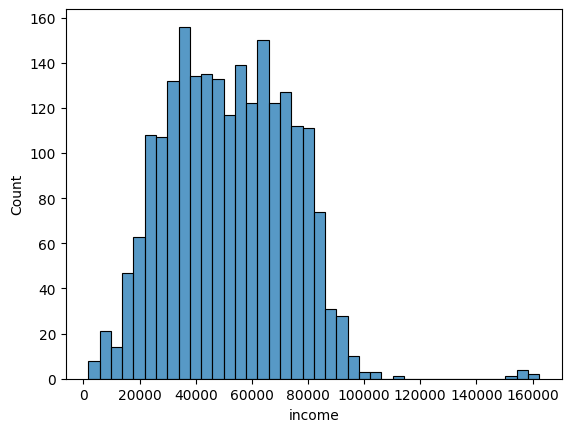

In [ ]:
import seaborn as sns
sns.histplot(df.income[df.income<600000],bins=40)

In [ ]:
df.income=df.income[df.income<200000]

In [ ]:
maritalspending = customer.groupby('Marital_Status')['TotalSpendings'].mean().sort_values(ascending=False)
maritalspending_df = pd.DataFrame(list(maritalspending.items()), columns=['Marital Status', 'Average Spending'])

plt.figure(figsize=(13,5))
sns.barplot(data = maritalspending_df, x="Average Spending", y="Marital Status", palette='rocket')

plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.xlabel('Average Spending', fontsize=13, labelpad=13)
plt.ylabel('Marital Status', fontsize=13, labelpad=13)

NameError: name 'customer' is not defined

In [14]:
df.family_size.replace({1:'Single',2:'Partner'},inplace=True)

In [15]:
fig = px.sunburst(df, path=['family_size','education', 'children'], values='spent', color='education')
fig.show()

In [17]:
df=df[df.clusters=='0']

In [18]:
fig = px.scatter(df, x='spent', y='income',size='children', color='family_size',
                 hover_name='income')

fig